In [15]:
#We load in the specific data needed
import polars as pl
import numpy as np
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [16]:
data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_tech_nonscaled.parquet')
datat = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_nonscaled.parquet')

# prc_filter = 0.125

# data = data[data['prc_option'] > prc_filter]
# datat = datat[datat['prc_option'] > prc_filter]


impl_volatility = 'impl_volatility_h_1_step'

test_data = datat[datat['date'] >= '2021-01-01']
total_train = data[data['date'] < '2021-01-01']

# data = data_sso[data_sso['prc_option'] > prc_filter]
# datat = datat_sso[datat_sso['prc_option'] > prc_filter]

# basic = ['moneyness', 'T', 'moneyness_squared', 'tau_squared', 'moneyness_tau']
basic = ['moneyness', 'T']
option_specific = ['cp_flag', 'spread_option', 'volume', 'prc_option', 'previous_iv']
macro_features = ['2Y_bond','FF_rate', 'gold_price','reces_indi', 'CLOSE_vix', 'hi-lo_vix']
# macro_features = ['1Y_bond','2Y_bond','FF_rate', 'gold_price','reces_indi','10Y_RIR', 'CLOSE_vix', 'hi-lo_vix']
stock_specific = ['BID', 'ASK', 'daily_return_indicator_stock', 'hi-lo_stock', 'PRC', "vol_stock", 'RET', 'spread_stock']

tickers = ['ticker_AAPL', 'ticker_AMZN', 'ticker_META', 'ticker_MSFT','ticker_NVDA', 'ticker_TSLA'  ]


totalList = ['moneyness', 'T'] + macro_features + option_specific + stock_specific + tickers

totalList = ['T',
 'moneyness',
 'previous_iv',
 'spread_option',
 '2Y_bond',
 'RET',
 'cp_flag',
 'ticker_TSLA',
 'ticker_AMZN']

# data_train = data_trains[data_trains['date'] < '2020-01-01']
# data_validate = data_trains[data_trains['date'] >= '2020-01-01']
tickers_groups = ['AMZN', 'TSLA', ['META', 'MSFT','NVDA', 'AAPL']]

In [17]:
formy = test_data[test_data['Ticker'] == 'TSLA']
formy

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step,dollar_volume,total_iv_weighted,previous_iv,previous_iv_all
173724,2021-01-04,1,715000,27.65,27.95,4284,3635,0.647433,0.631395,0.007622,...,0,0,1,TSLA,0.491547,0.933340,119095.200,77106.162622,0.594084,0.492819
173743,2021-01-04,0,667500,4.00,4.15,1029,421,0.786709,-0.130492,0.003529,...,0,0,1,TSLA,0.615203,0.902900,4193.175,3298.808511,0.594084,0.492819
173744,2021-01-04,0,670000,4.30,4.40,10047,3153,0.780195,-0.138524,0.003708,...,0,0,1,TSLA,0.608685,0.905850,43704.450,34097.993368,0.594084,0.492819
173745,2021-01-04,0,672500,4.55,4.65,667,223,0.771257,-0.146289,0.003891,...,0,0,1,TSLA,0.602109,0.907600,3068.200,2366.370727,0.594084,0.492819
173746,2021-01-04,0,675000,4.85,4.95,4547,2011,0.764238,-0.155047,0.004082,...,0,0,1,TSLA,0.594580,0.910586,22280.300,17027.451911,0.594084,0.492819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273613,2021-12-30,0,980000,0.46,0.48,4194,4025,0.870581,-0.025073,0.001202,...,0,0,1,TSLA,0.610330,1.069063,1971.180,1716.071856,0.534742,0.474367
273614,2021-12-30,0,890000,0.11,0.15,379,3447,1.393724,-0.005131,0.000190,...,0,0,1,TSLA,0.694156,1.551327,49.270,68.668781,0.534742,0.474367
273615,2021-12-30,1,1185000,0.16,0.19,1795,1651,0.840809,0.010984,0.000615,...,0,0,1,TSLA,0.645521,0.819447,314.125,264.119127,0.534742,0.474367
273737,2021-12-30,1,1195000,0.13,0.18,1247,1299,0.887061,0.009385,0.000508,...,0,0,1,TSLA,0.653035,0.864253,193.285,171.455585,0.534742,0.474367


In [42]:
# from sklearn.metrics import mean_squared_error
# from sklearn.ensemble import RandomForestRegressor
# from joblib import Parallel, delayed
# from sklearn.model_selection import ParameterGrid
# import pandas as pd
# import numpy as np

# def evaluate_params(params, train_data, validation_data, IV, selected_features, verbose=0):
#     """
#     Perform walk-forward validation for a single set of parameters.
#     """
#     rf_model = RandomForestRegressor(random_state=42, **params)  # Set current hyperparameters
#     current_train_data = train_data.copy()  # Start with the initial training data (Year 1)
#     total_rmse = 0
#     count = 0

#     if verbose >= 1:
#         print(f"Evaluating parameters: {params}")

#     # Loop over each day in the validation set (Year 2)
#     for date in pd.date_range(start='2020-01-01', end='2020-12-31'):
#         val_data_day = validation_data[validation_data['date'] == date]
#         if val_data_day.empty:
#             continue

#         # Separate features and target for validation
#         y_val = val_data_day[IV]
#         X_val = val_data_day[selected_features]

#         # Train the model on current training data
#         data_y_train = current_train_data[IV]
#         features_train = current_train_data[selected_features]
#         rf_model.fit(features_train, data_y_train)

#         # Predict on validation set and compute RMSE
#         y_pred = rf_model.predict(X_val)
#         rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#         total_rmse += rmse
#         count += 1

#         if verbose == 2:
#             print(f"  Date: {date.date()}, RMSE: {rmse:.4f}")

#         # Add the validation data to the training set for the next iteration
#         current_train_data = pd.concat([current_train_data, val_data_day])

#     # Average RMSE for this parameter combination
#     avg_rmse = total_rmse / count
#     if verbose >= 1:
#         print(f"  Average RMSE for parameters {params}: {avg_rmse:.4f}")

#     return params, avg_rmse

# def walk_forward_validation_tuning(IV, combined_data, selected_features, verbose=0, n_jobs=-1):
#     """
#     Perform Walk-Forward Validation for hyperparameter tuning with parallel processing.
#     """
#     # Split the data
#     train_data = combined_data[combined_data['date'].dt.year == 2019]  # Year 1 - initial training set
#     validation_data = combined_data[combined_data['date'].dt.year == 2020]  # Year 2 - rolling validation for tuning

#     # Define the parameter grid
#     param_grid = {
#         'n_estimators': [75],
#         'max_features': [7],
#         'min_samples_leaf': [2],
#         'min_samples_split': [2],
#         'max_depth': [10]
#     }

#     # Use joblib to parallelize the evaluation of each parameter combination
#     results = Parallel(n_jobs=n_jobs)(
#         delayed(evaluate_params)(params, train_data, validation_data, IV, selected_features, verbose)
#         for params in ParameterGrid(param_grid)
#     )

#     # Find the best parameters based on the lowest RMSE
#     best_params, best_score = min(results, key=lambda x: x[1])

#     print(f"Best hyperparameters found: {best_params} with average RMSE: {best_score:.4f}")
#     return best_params

# # Example usage
# hyperparameter_tune = walk_forward_validation_tuning('impl_volatility', data, totalList, verbose=1, n_jobs=-1)


Retraining final RandomForest model on combined 2019 and 2020 data...


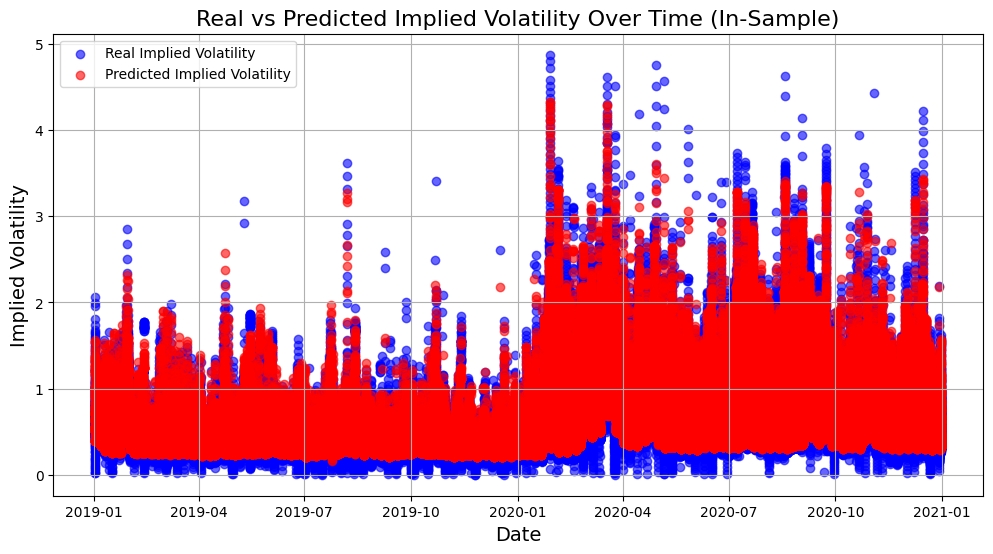

In-sample RMSE: 0.1211
In-sample R²: 0.9198


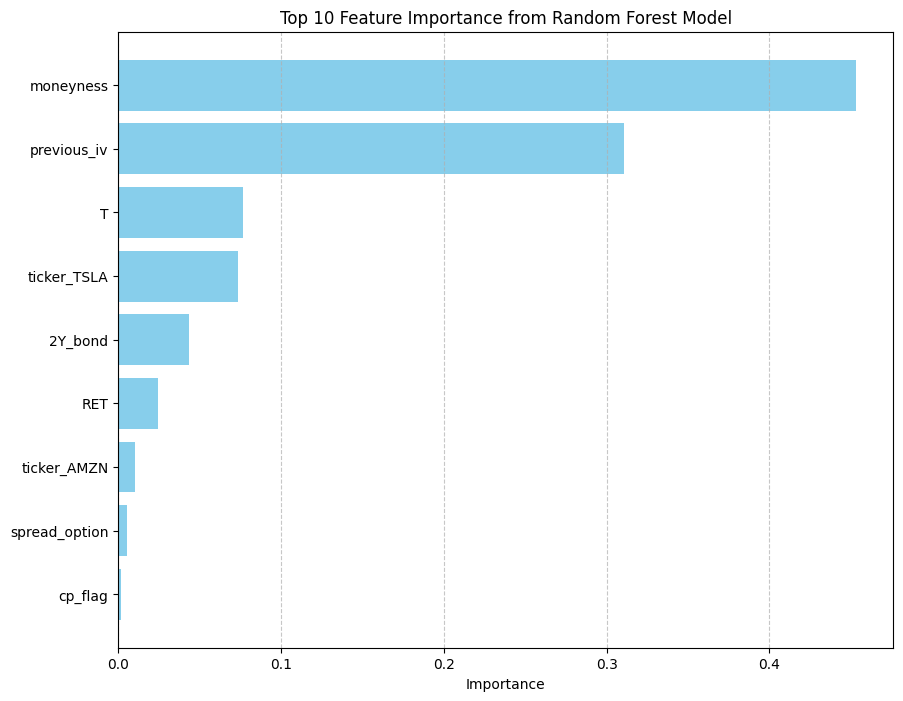

Final model and selected features have been saved.


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

def retrain_final_model_rf(IV, data, selected_features, n_estimators, max_depth, max_features, min_samples_leaf, min_samples_split, random_state=42, verbose=0):
    """
    Retrain the final RandomForest model on combined 2019 and 2020 data with specified parameters
    and plot feature importance.
    """
    if verbose >= 1:
        print("Retraining final RandomForest model on combined 2019 and 2020 data...")

    # Combine training and validation data (2019 and 2020)
    combined_data = data[data['date'].dt.year <= 2020]
    combined_x = combined_data[selected_features]
    combined_y = combined_data[IV]

    # Train RandomForest with the specified parameters
    final_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        # min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        random_state=random_state
    )
    final_model.fit(combined_x, combined_y)

    # In-sample predictions and score calculation
    y_pred_in_sample = final_model.predict(combined_x)
    in_sample_rmse = np.sqrt(mean_squared_error(combined_y, y_pred_in_sample))
    in_sample_r2 = r2_score(combined_y, y_pred_in_sample)

    plot_real_vs_predicted(combined_data, combined_y, y_pred_in_sample, 'In-Sample')

    if verbose >= 1:
        print(f"In-sample RMSE: {in_sample_rmse:.4f}")
        print(f"In-sample R²: {in_sample_r2:.4f}")

    # Extract feature importances
    importance = final_model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importance
    }).sort_values(by='Importance', ascending=False)

    # Normalize importance so that the sum is 1
    importance_df['Importance'] = importance_df['Importance'] / importance_df['Importance'].sum()

    # Select the top 10 features
    top_10_features_df = importance_df.head(10)

    # Plot the normalized importance of the top 10 features
    plt.figure(figsize=(10, 8))
    plt.barh(top_10_features_df['Feature'], top_10_features_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.title('Top 10 Feature Importance from Random Forest Model')
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

    # Save the final model and selected features
    joblib.dump(final_model, 'final_random_forest_model.pkl')
    joblib.dump(selected_features, 'selected_features.pkl')

    print("Final model and selected features have been saved.")
    return final_model, top_10_features_df

def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time.

    Parameters:
    test_data (pd.DataFrame): The test dataset containing the date information.
    real_values (np.array or pd.Series): The real implied volatility values.
    predicted_values (np.array or pd.Series): The predicted implied volatility values.
    title (str): The title for the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming you have defined n_estimators, max_depth, selected_features, and other relevant data
n_estimators = 100  # Example value; replace with the optimal value from your tuning
max_depth = 10      # Example value; replace with the optimal value from your tuning
max_features = 5    # Example value; replace with the optimal value from your tuning
min_samples_leaf = 2  # Example value; replace with the optimal value from your tuning
min_samples_split = 2  # Example value; replace with the optimal value from your tuning

# Retrain the final model on the combined dataset and plot top 10 normalized features
final_rf_model, selected_features_final = retrain_final_model_rf(
    impl_volatility, data, totalList, n_estimators, max_depth, max_features, min_samples_leaf, min_samples_split, verbose=1
)


In [30]:
selected_features_final["Feature"].tolist()

['previous_iv', 'moneyness', 'T', 'ticker_TSLA', 'cp_flag']

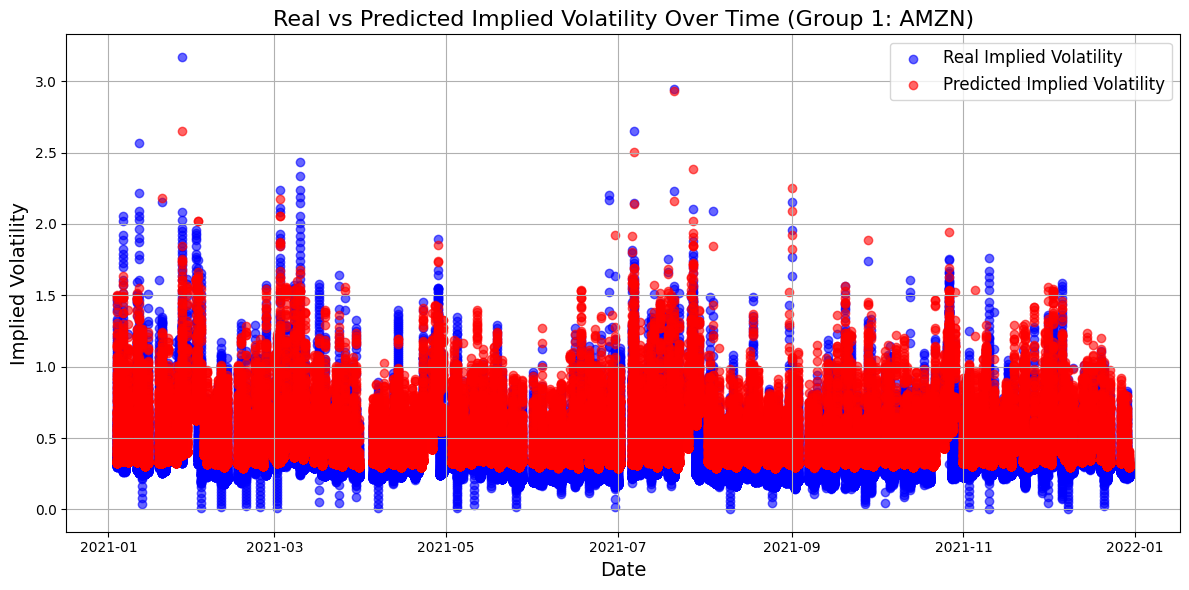

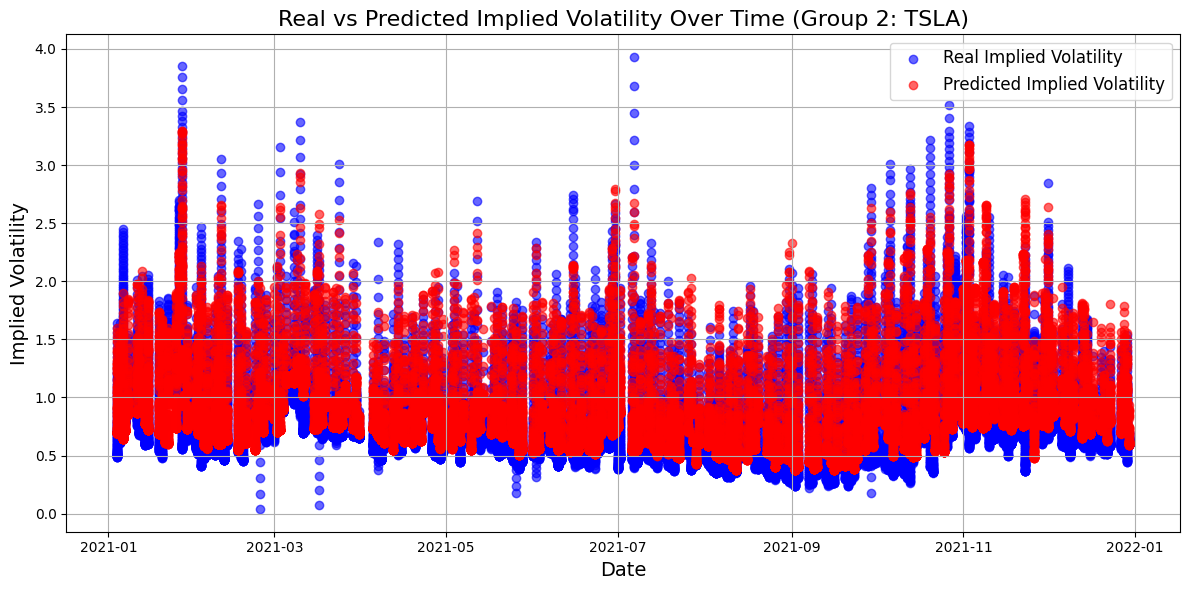

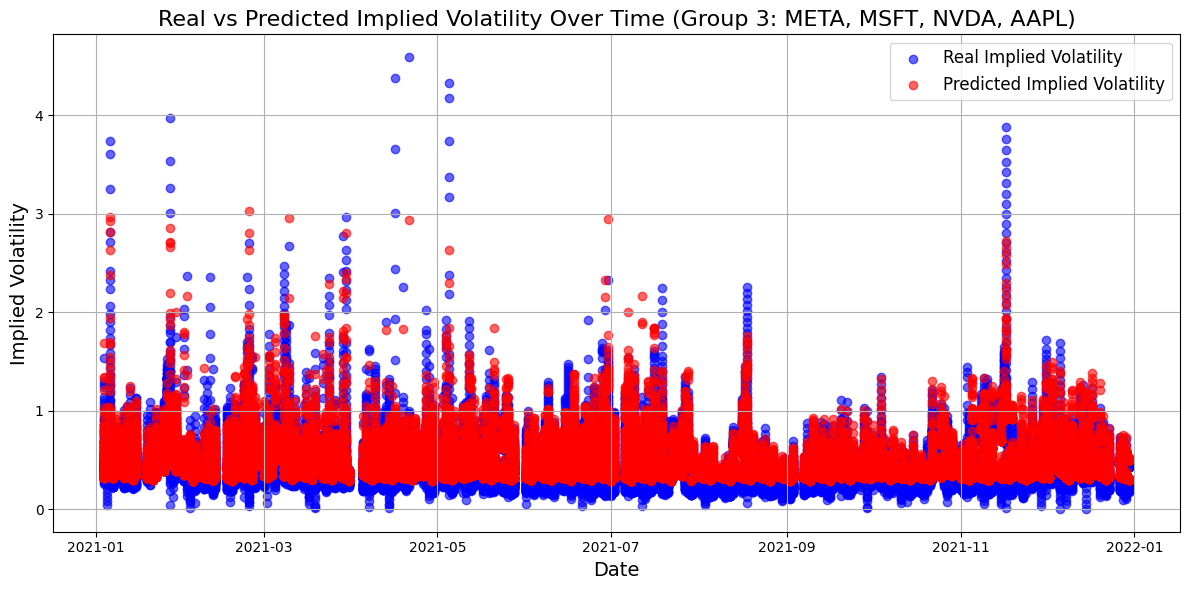

28054
28054
[ 0.045264    0.04573531  0.04605064 ... -0.06838125 -0.05826249
 -0.06340195]
Daily average errors calculated for 250 days.
Newey-West Standard Error (Based on Daily Averages): 0.0054523555345444156
Daily average errors and Newey-West statistics saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/rf_META_MSFT_NVDA_AAPL.csv
Overall Combined RMSE: 0.14176524006213062
Overall Combined R²: 0.7380020479660923
Group 1:
  Tickers: ['AMZN']
  Group RMSE: 0.11507199308984215
  Group R²: 0.7912215843234439

Group 2:
  Tickers: ['TSLA']
  Group RMSE: 0.1931174781673824
  Group R²: 0.803627663852591

Group 3:
  Tickers: ['META', 'MSFT', 'NVDA', 'AAPL']
  Group RMSE: 0.14176524006213062
  Group R²: 0.7380020479660923



/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_4600/1126262472.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['Errors'] = errors_test  # Add errors to the test dataset


In [23]:
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    
    Parameters:
    - errors: Array-like of prediction errors
    - lag: Maximum lag to use for the Newey-West estimator (default is 1)
    
    Returns:
    - Newey-West standard error of the prediction errors
    """
    X = np.ones(len(errors))  # Constant term for OLS
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    return ols_model.bse[0]  # Standard error of the constant term

def predict_test_data_by_groups_with_scatter_plots(IV, test_data, model, selected_features, ticker_groups, n_runs=1):

    """
    Predict the target variable for the test set using the trained model,
    calculate RMSE and R² for each ticker, and compute weighted overall metrics.
    Additionally, compute combined overall metrics using all data.

    Parameters:
    IV (str): The name of the independent variable to predict.
    test_data (pd.DataFrame): The test dataset.
    model: The trained model (e.g., RandomForest).
    selected_features (list): The list of features used for modeling.

    Returns:
    dict: Contains RMSE and R² values for each ticker, overall weighted metrics, 
          and combined overall metrics.
    """
    group_results = {}

    for group_idx, group in enumerate(ticker_groups):
        if isinstance(group, str):
            tickers = [group]
        else:
            tickers = group

        # Filter data for the current group
        group_data = test_data[test_data['Ticker'].isin(tickers)]

        combined_actual = []
        combined_predicted = []
        combined_dates = []

        for ticker in tickers:
            ticker_data = group_data[group_data['Ticker'] == ticker]
            y_actual = ticker_data[IV]
            X = ticker_data[selected_features]
            dates = ticker_data['date']

            # Aggregate real, predicted, and date values for group plotting
            for _ in range(n_runs):
                y_pred = model.predict(X)
                combined_actual.extend(y_actual)
                combined_predicted.extend(y_pred)
                combined_dates.extend(dates)

        # Combined metrics for the group
        combined_actual = np.array(combined_actual)
        combined_predicted = np.array(combined_predicted)
        combined_dates = pd.to_datetime(combined_dates)

        group_rmse = np.sqrt(mean_squared_error(combined_actual, combined_predicted))
        group_r2 = r2_score(combined_actual, combined_predicted)

        group_results[f'Group {group_idx + 1}'] = {
            'Group_Tickers': tickers,
            'Group_RMSE': group_rmse,
            'Group_R²': group_r2
        }

        # Plot real vs predicted IV for the group as scatter plot
        plot_real_vs_predicted_scatter(group_data, combined_dates, combined_actual, combined_predicted, f'Group {group_idx + 1}: {", ".join(tickers)}')


        # Calculate overall metrics based on combined data (not weighted)
    combined_actual = np.array(combined_actual)
    combined_predicted = np.array(combined_predicted)
    combined_predicted = combined_predicted.flatten()
    print(len(combined_actual))
    print(len(combined_predicted))


    # Example calculation
    errors_test = combined_actual - combined_predicted
    print(errors_test)
    group_data['Errors'] = errors_test  # Add errors to the test dataset

    # Group errors by date and calculate daily averages
    if 'date' in group_data.columns:
        daily_avg_errors = group_data.groupby('date')['Errors'].mean()
        print(f"Daily average errors calculated for {len(daily_avg_errors)} days.")
    else:
        raise ValueError("The dataset does not contain a 'date' column.")

    # Calculate Newey-West standard error using daily averages
    nw_std_error_test = newey_west_standard_error(daily_avg_errors.values, lag=1)
    print(f"Newey-West Standard Error (Based on Daily Averages): {nw_std_error_test}")

    # Save the daily errors and Newey-West standard error into a dynamically named CSV
    group_name = "_".join(tickers)  # Join tickers with an underscore
    file_path = f'/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/rf_{group_name}.csv'

    # Create a DataFrame with daily averaged errors and repeated Newey-West standard error
    dm_test_data = pd.DataFrame({
        'Date': daily_avg_errors.index,
        'Daily Avg Errors': daily_avg_errors.values,
        'Newey-West Std Error': [nw_std_error_test] * len(daily_avg_errors)
    })

    # Save the DataFrame to a CSV
    dm_test_data.to_csv(file_path, index=False)
    print(f"Daily average errors and Newey-West statistics saved to {file_path}")

    overall_combined_rmse = np.sqrt(mean_squared_error(combined_actual, combined_predicted))
    overall_combined_r2 = r2_score(combined_actual, combined_predicted)

    print(f'Overall Combined RMSE: {overall_combined_rmse}')
    print(f'Overall Combined R²: {overall_combined_r2}')

    # return combined_actual, combined_predicted, {
    #     'Overall_Combined_RMSE': overall_combined_rmse,
    #     'Overall_Combined_R²': overall_combined_r2
    # }

    return group_results


def plot_real_vs_predicted_scatter(test_data, dates, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time using scatter plots.

    Parameters:
    test_data (pd.DataFrame): The test dataset containing the date information.
    dates (array-like): Dates for the test data.
    real_values (array-like): Real implied volatility values.
    predicted_values (array-like): Predicted implied volatility values.
    title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(dates, real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    plt.scatter(dates, predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
ticker_groups = ['AMZN', 'TSLA', ['META', 'MSFT', 'NVDA', 'AAPL']]
# ticker_groups = ['AMZN']
results = predict_test_data_by_groups_with_scatter_plots(
    IV=impl_volatility,
    test_data=datat,
    model=final_rf_model,
    selected_features=totalList,
    ticker_groups=ticker_groups,
    n_runs=1
)
# Print results for each group
for group_name, group_result in results.items():
    print(f"{group_name}:")
    print(f"  Tickers: {group_result['Group_Tickers']}")
    print(f"  Group RMSE: {group_result['Group_RMSE']}")
    print(f"  Group R²: {group_result['Group_R²']}")
    # print(f"  Number of Observations: {group_result['Number of Observations']}")
    print()



In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    """
    X = np.ones(len(errors))  # Constant term
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    return ols_model.bse[0]  # Standard error of the constant term

def predict_test_data_by_groups_with_scatter_plots(IV, test_data, model, selected_features, ticker_groups, n_runs=1):
    """
    Predict the target variable for the test set using the trained model,
    calculate RMSE and R² for each group, and save results dynamically for each group.
    """
    group_results = {}

    for group_idx, group in enumerate(ticker_groups):
        tickers = [group] if isinstance(group, str) else group

        # Filter data for the current group
        group_data = test_data[test_data['Ticker'].isin(tickers)]

        if group_data.empty:
            print(f"Warning: No data available for group {group_idx + 1}: {', '.join(tickers)}")
            continue

        combined_actual = []
        combined_predicted = []
        combined_dates = []

        for ticker in tickers:
            ticker_data = group_data[group_data['Ticker'] == ticker]
            y_actual = ticker_data[IV]
            X = ticker_data[selected_features]
            dates = ticker_data['date']

            # Predict and aggregate results
            for _ in range(n_runs):
                y_pred = model.predict(X)
                combined_actual.extend(y_actual)
                combined_predicted.extend(y_pred)
                combined_dates.extend(dates)

        # Combined metrics for the group
        combined_actual = np.array(combined_actual)
        combined_predicted = np.array(combined_predicted)
        combined_dates = pd.to_datetime(combined_dates)

        group_rmse = np.sqrt(mean_squared_error(combined_actual, combined_predicted))
        group_r2 = r2_score(combined_actual, combined_predicted)

        group_results[f'Group {group_idx + 1}'] = {
            'Group_Tickers': tickers,
            'Group_RMSE': group_rmse,
            'Group_R²': group_r2
        }

        # Save results to CSV
        group_name = "_".join(tickers)
        file_path = f'/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/rf_{group_name}.csv'

        if combined_actual.size > 0:
            # Calculate Newey-West standard error
            errors_test = combined_actual - combined_predicted
            group_data['Errors'] = errors_test
            daily_avg_errors = group_data.groupby('date')['Errors'].mean()
            nw_std_error_test = newey_west_standard_error(daily_avg_errors.values, lag=1)

            results_df = pd.DataFrame({
                'Date': daily_avg_errors.index,
                'Daily Avg Errors': daily_avg_errors.values,
                'Newey-West Std Error': [nw_std_error_test] * len(daily_avg_errors)
            })

            results_df.to_csv(file_path, index=False)
            print(f"Results for group {group_idx + 1} saved to {file_path}")
        else:
            print(f"Warning: No predictions were made for group {group_idx + 1}: {group_name}")

    return group_results


def plot_real_vs_predicted_scatter(test_data, dates, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time using scatter plots.
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(dates, real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    plt.scatter(dates, predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage
ticker_groups = ['AMZN', 'TSLA', ['META', 'MSFT', 'NVDA', 'AAPL']]
# Replace the following variables with actual data and model
# datat = your_test_data
# impl_volatility = "your_target_variable"
# final_rf_model = your_trained_model
# totalList = your_feature_list

results = predict_test_data_by_groups_with_scatter_plots(
    IV=impl_volatility,
    test_data=datat,
    model=final_rf_model,
    selected_features=totalList,
    ticker_groups=ticker_groups,
    n_runs=1
)

# Print results for each group
for group_name, group_result in results.items():
    print(f"{group_name}:")
    print(f"  Tickers: {group_result['Group_Tickers']}")
    print(f"  Group RMSE: {group_result['Group_RMSE']}")
    print(f"  Group R²: {group_result['Group_R²']}")
    print()

# Define the correct feature order
correct_order = [
    'T',
    'moneyness',
    'previous_iv',
    'ticker_TSLA',
    'cp_flag',
    '2Y_bond',
    'ticker_AMZN',
    'RET',
    'spread_option'
]

# Initialize lists to store feature importance values for each group
group1_importance_enet = []
group2_importance_enet = []
group3_importance_enet = []

# Extract and reorder the feature importance values for each group
for group_name, results in group_importance_results.items():
    importance_df = results['Feature Importance']
    # Reorder the importance values to match the correct order
    importance_dict = dict(zip(importance_df['Feature'], importance_df['Importance']))
    reordered_importance = [importance_dict.get(feature, 0) for feature in correct_order]
    if group_name == "Group 1 (AMZN)":
        group1_importance_enet = reordered_importance
    elif group_name == "Group 2 (TSLA)":
        group2_importance_enet = reordered_importance
    elif group_name == "Group 3 (META, MSFT, NVDA, AAPL)":
        group3_importance_enet = reordered_importance

# Output the lists for verification
print("Group 1 ENet Importance (AMZN) in correct order:", group1_importance_enet)
print("Group 2 ENet Importance (TSLA) in correct order:", group2_importance_enet)
print("Group 3 ENet Importance (META, MSFT, NVDA, AAPL) in correct order:", group3_importance_enet)



/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_4600/23932416.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['Errors'] = errors_test
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_4600/23932416.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['Errors'] = errors_test


Results for group 1 saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/rf_AMZN.csv
Results for group 2 saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/rf_TSLA.csv
Results for group 3 saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/rf_META_MSFT_NVDA_AAPL.csv
Group 1:
  Tickers: ['AMZN']
  Group RMSE: 0.11507199308984215
  Group R²: 0.7912215843234439

Group 2:
  Tickers: ['TSLA']
  Group RMSE: 0.1931174781673824
  Group R²: 0.803627663852591

Group 3:
  Tickers: ['META', 'MSFT', 'NVDA', 'AAPL']
  Group RMSE: 0.14176524006213062
  Group R²: 0.7380020479660923

Group 1 ENet Importance (AMZN) in correct order: [0.0758989119921261, 0.901544475845257, 0.00706932691019873, 0.0, 0.0, 0.0, 0.015116813143825776, 0.0, 0.000370472108592274]
Group 2 ENet Importance (TSLA) in correct order: [0.16981315

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_4600/23932416.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['Errors'] = errors_test


Calculating feature importance for group: Group 1 (AMZN)
Baseline R² (OOS): 0.7912


/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Feature: T, Baseline R²: 0.7912, Perturbed R²: 0.5226, Drop: 0.2686
Feature: moneyness, Baseline R²: 0.7912, Perturbed R²: -2.3994, Drop: 3.1906
Feature: previous_iv, Baseline R²: 0.7912, Perturbed R²: 0.7662, Drop: 0.0250


/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Feature: spread_option, Baseline R²: 0.7912, Perturbed R²: 0.7899, Drop: 0.0013
Feature: 2Y_bond, Baseline R²: 0.7912, Perturbed R²: 0.8052, Drop: 0.0000


/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Feature: RET, Baseline R²: 0.7912, Perturbed R²: 0.7957, Drop: 0.0000
Feature: cp_flag, Baseline R²: 0.7912, Perturbed R²: 0.7915, Drop: 0.0000


/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Feature: ticker_TSLA, Baseline R²: 0.7912, Perturbed R²: 0.7912, Drop: 0.0000
Feature: ticker_AMZN, Baseline R²: 0.7912, Perturbed R²: 0.7377, Drop: 0.0535
Feature Importance for Group 1 (AMZN):
         Feature  Importance
1      moneyness    0.901544
0              T    0.075899
8    ticker_AMZN    0.015117
2    previous_iv    0.007069
3  spread_option    0.000370
4        2Y_bond    0.000000
5            RET    0.000000
6        cp_flag    0.000000
7    ticker_TSLA    0.000000

Calculating feature importance for group: Group 2 (TSLA)
Baseline R² (OOS): 0.8036


/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Feature: T, Baseline R²: 0.8036, Perturbed R²: 0.6045, Drop: 0.1991
Feature: moneyness, Baseline R²: 0.8036, Perturbed R²: 0.0015, Drop: 0.8021
Feature: previous_iv, Baseline R²: 0.8036, Perturbed R²: 0.6412, Drop: 0.1624
Feature: spread_option, Baseline R²: 0.8036, Perturbed R²: 0.8034, Drop: 0.0003


/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Feature: 2Y_bond, Baseline R²: 0.8036, Perturbed R²: 0.8031, Drop: 0.0005
Feature: RET, Baseline R²: 0.8036, Perturbed R²: 0.8037, Drop: 0.0000
Feature: cp_flag, Baseline R²: 0.8036, Perturbed R²: 0.8041, Drop: 0.0000


/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Feature: ticker_TSLA, Baseline R²: 0.8036, Perturbed R²: 0.7955, Drop: 0.0081
Feature: ticker_AMZN, Baseline R²: 0.8036, Perturbed R²: 0.8036, Drop: 0.0000
Feature Importance for Group 2 (TSLA):
         Feature  Importance
1      moneyness    0.684023
0              T    0.169813
2    previous_iv    0.138529
7    ticker_TSLA    0.006941
4        2Y_bond    0.000458
3  spread_option    0.000236
5            RET    0.000000
6        cp_flag    0.000000
8    ticker_AMZN    0.000000

Calculating feature importance for group: Group 3 (META, MSFT, NVDA, AAPL)
Baseline R² (OOS): 0.7380
Feature: T, Baseline R²: 0.7380, Perturbed R²: 0.4909, Drop: 0.2471


/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Feature: moneyness, Baseline R²: 0.7380, Perturbed R²: -2.0995, Drop: 2.8376
Feature: previous_iv, Baseline R²: 0.7380, Perturbed R²: 0.5969, Drop: 0.1411
Feature: spread_option, Baseline R²: 0.7380, Perturbed R²: 0.7380, Drop: 0.0000
Feature: 2Y_bond, Baseline R²: 0.7380, Perturbed R²: 0.7424, Drop: 0.0000


/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Feature: RET, Baseline R²: 0.7380, Perturbed R²: 0.7371, Drop: 0.0009
Feature: cp_flag, Baseline R²: 0.7380, Perturbed R²: 0.7379, Drop: 0.0001
Feature: ticker_TSLA, Baseline R²: 0.7380, Perturbed R²: 0.7380, Drop: 0.0000
Feature: ticker_AMZN, Baseline R²: 0.7380, Perturbed R²: 0.7380, Drop: 0.0000
Feature Importance for Group 3 (META, MSFT, NVDA, AAPL):
         Feature  Importance
1      moneyness    0.879387
0              T    0.076582
2    previous_iv    0.043725
5            RET    0.000267
6        cp_flag    0.000036
3  spread_option    0.000003
4        2Y_bond    0.000000
7    ticker_TSLA    0.000000
8    ticker_AMZN    0.000000

Baseline R² for Group 1 (AMZN): 0.7912


/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


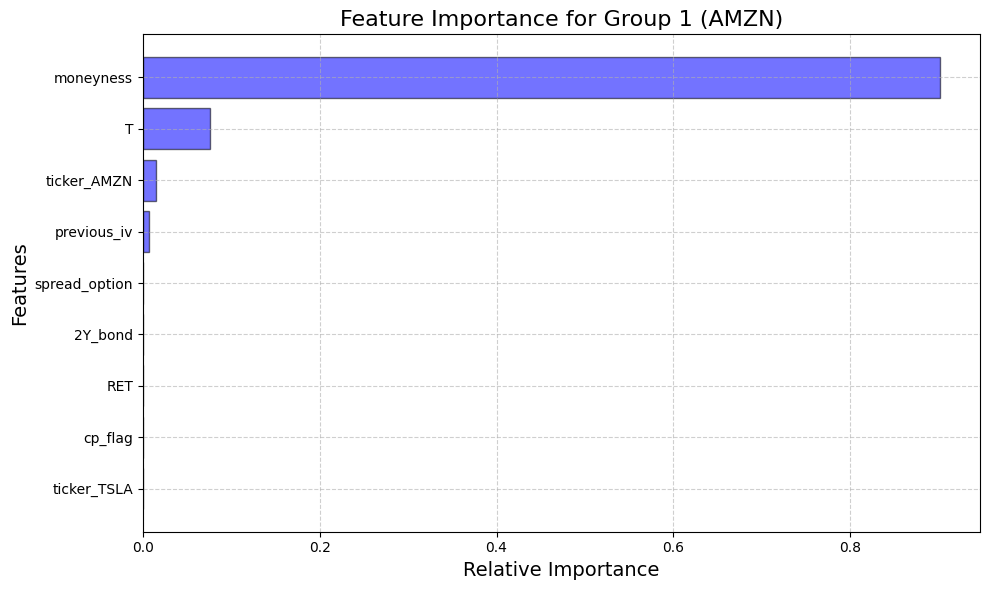

Baseline R² for Group 2 (TSLA): 0.8036


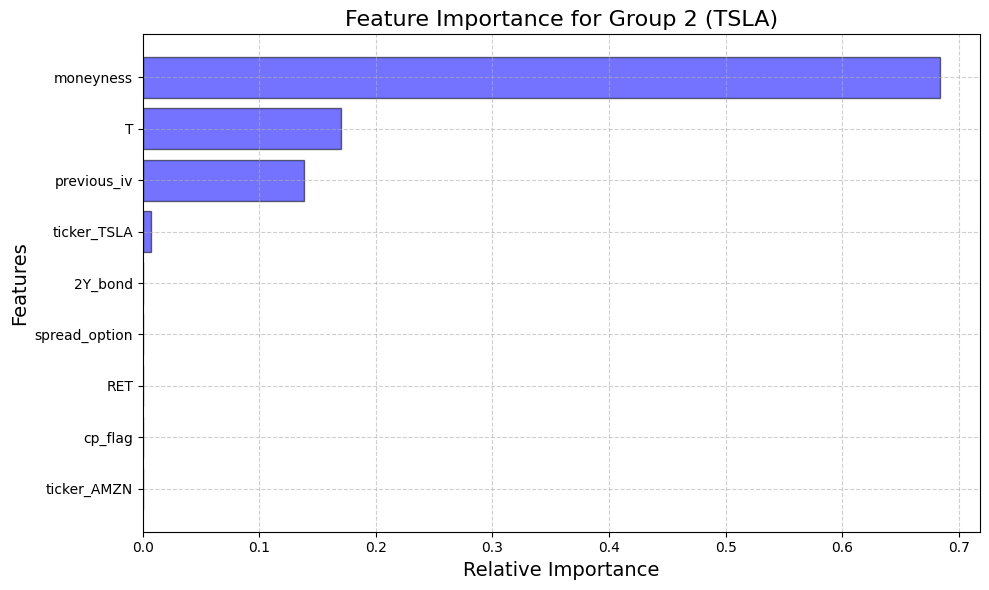

Baseline R² for Group 3 (META, MSFT, NVDA, AAPL): 0.7380


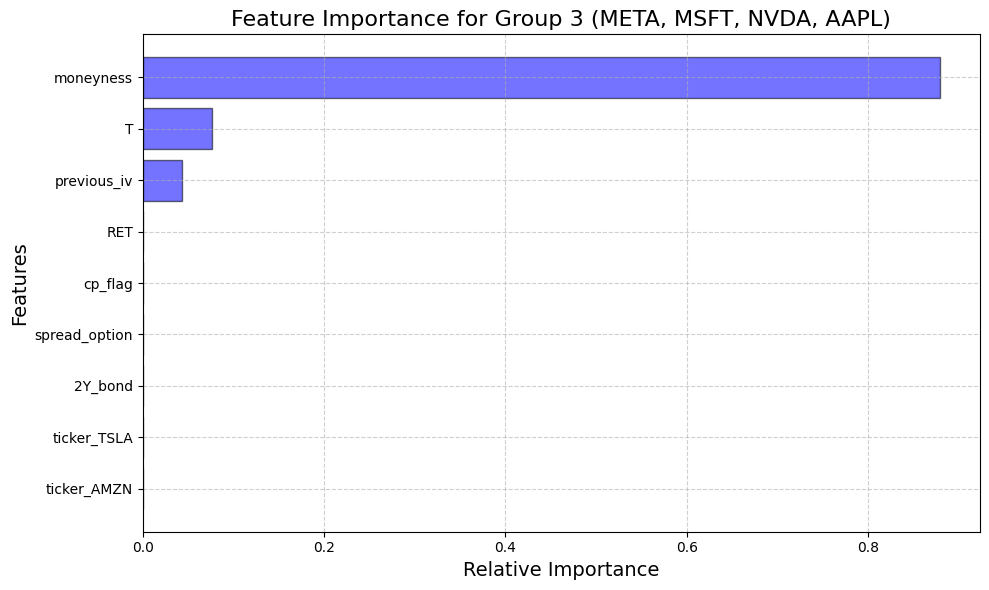

In [9]:
def calculate_feature_importance_r2_rf(data_test, features, target, model):
    """
    Calculate feature importance for NN based on the relative drop in R²_oos when a feature is set to zero.

    Parameters:
    - data_test: Test dataset
    - features: List of feature names
    - target: Target variable (e.g., implied volatility)
    - model: Trained neural network model
    
    Returns:
    - importance_df: DataFrame with feature importance values.
    - baseline_r2: Baseline R²_oos value.
    """
    # Prepare the test dataset
    X_test = data_test[features].values
    y_test = data_test[target].values

    # Predict on the test data and calculate baseline R²_oos
    y_test_pred = model.predict(X_test).flatten()
    baseline_r2 = r2_score(y_test, y_test_pred)
    print(f"Baseline R² (OOS): {baseline_r2:.4f}")

    # Calculate the drop in R²_oos for each feature
    r2_drops = []
    for i, feature in enumerate(features):
        # Perturb the test data by setting the feature column to zero
        X_test_zeroed = X_test.copy()
        X_test_zeroed[:, i] = 0

        # Predict and calculate R²_oos
        y_test_pred_zeroed = model.predict(X_test_zeroed).flatten()
        r2_zeroed = r2_score(y_test, y_test_pred_zeroed)
        r2_drop = max(0, baseline_r2 - r2_zeroed)  # Ensure the drop is non-negative
        r2_drops.append(r2_drop)

        print(f"Feature: {feature}, Baseline R²: {baseline_r2:.4f}, Perturbed R²: {r2_zeroed:.4f}, Drop: {r2_drop:.4f}")

    # Normalize the importance scores
    r2_importance = np.array(r2_drops)
    if r2_importance.sum() > 0:
        r2_importance = r2_importance / r2_importance.sum()  # Normalize to sum to 1
    else:
        r2_importance = np.zeros_like(r2_importance)  # Handle edge case where all drops are zero

    # Create a DataFrame for feature importance
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': r2_importance
    }).sort_values(by='Importance', ascending=False)

    return importance_df, baseline_r2

def plot_feature_importance(importance_df, title="Feature Importance"):
    """
    Plot feature importance as a bar chart.
    
    Parameters:
    - importance_df: DataFrame containing feature names and importance scores.
    - title: Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue', edgecolor='black', alpha=0.55)
    plt.xlabel('Relative Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
def calculate_feature_importance_r2_rf_grouped(data_test, features, target, model, groups):
    """
    Calculate feature importance for NN for each group of tickers based on the relative drop in R²_oos.

    Parameters:
    - data_test: Test dataset.
    - features: List of feature names.
    - target: Target variable (e.g., implied volatility).
    - model: Trained neural network model.
    - groups: Dictionary where keys are group names and values are lists of tickers in each group.

    Returns:
    - group_importance_results: Dictionary of feature importance DataFrames for each group.
    """
    group_importance_results = {}

    for group_name, tickers in groups.items():
        print(f"Calculating feature importance for group: {group_name}")
        
        # Filter the test dataset for the current group
        group_data = data_test[data_test['Ticker'].isin(tickers)]
        
        # Calculate feature importance for the group
        importance_df, baseline_r2 = calculate_feature_importance_r2_rf(
            data_test=group_data,
            features=features,
            target=target,
            model=model
        )
        
        group_importance_results[group_name] = {
            'Feature Importance': importance_df,
            'Baseline R²': baseline_r2
        }

        print(f"Feature Importance for {group_name}:\n{importance_df}\n")

    return group_importance_results


# Define groups of tickers
ticker_groups = {
    "Group 1 (AMZN)": ["AMZN"],
    "Group 2 (TSLA)": ["TSLA"],
    "Group 3 (META, MSFT, NVDA, AAPL)": ["META", "MSFT", "NVDA", "AAPL"]
}

# Calculate feature importance for each group
group_importance_results = calculate_feature_importance_r2_rf_grouped(
    data_test=datat,
    features=totalList,
    target=impl_volatility,
    model=final_rf_model,  # Trained NN model
    groups=ticker_groups
)

# Plot feature importance for each group
for group_name, results in group_importance_results.items():
    print(f"Baseline R² for {group_name}: {results['Baseline R²']:.4f}")
    plot_feature_importance(results['Feature Importance'], title=f"Feature Importance for {group_name}")


In [34]:
# feature_importance_rf["Importance"].tolist()
feature_importance_rf["Feature"].tolist()

['moneyness',
 'T',
 'previous_iv',
 'ticker_AMZN',
 '2Y_bond',
 'ticker_TSLA',
 'RET',
 'spread_option',
 'cp_flag']

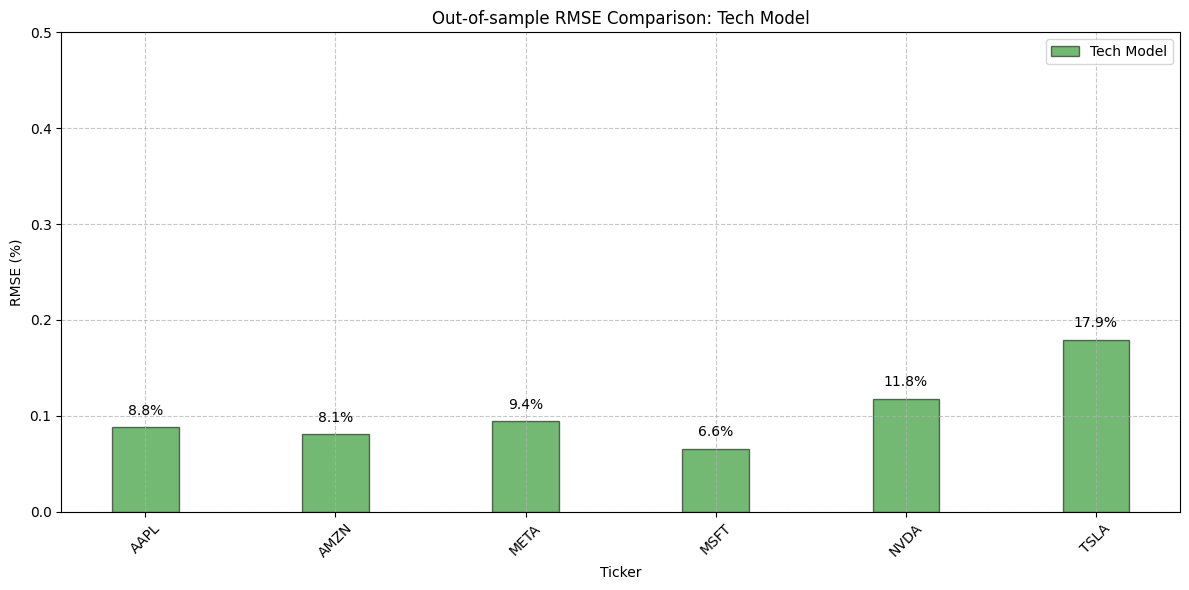

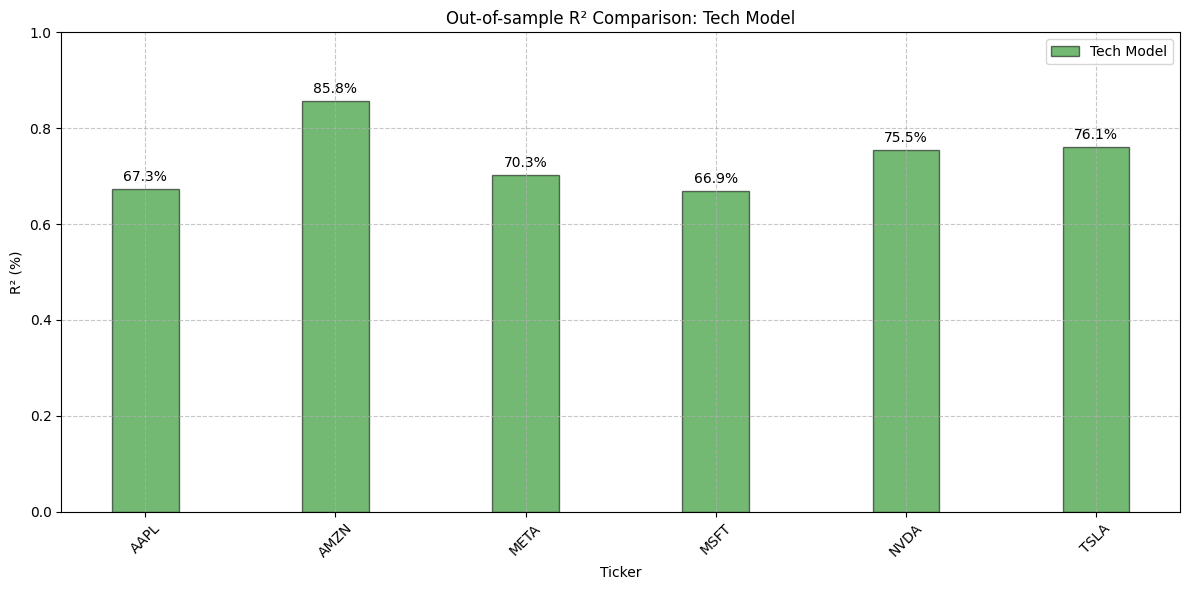

In [21]:
# Convert lists to DataFrames for easier plotting
results_list_all_df = pd.DataFrame(results_list_all).set_index('Ticker').sort_index()

# Define the x locations for the groups and bar width
x = np.arange(len(results_list_all_df.index))
width = 0.35  # Width of the bars

# Plot RMSE comparison
plt.figure(figsize=(12, 6))
bars_all_rmse = plt.bar(x, results_list_all_df['RMSE'], width=width, label='Tech Model', color='green', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for RMSE (converted to percentage format)
for bar in bars_all_rmse:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Ticker')
plt.ylabel('RMSE (%)')
plt.title('Out-of-sample RMSE Comparison: Tech Model')
plt.xticks(ticks=x, labels=results_list_all_df.index, rotation=45)
plt.legend()
plt.ylim([0, 0.5])  # Adjusted for percentage scale
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot R² comparison
plt.figure(figsize=(12, 6))
bars_all_r2 = plt.bar(x, results_list_all_df['R²'], width=width, label='Tech Model', color='green', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for R² (converted to percentage format)
for bar in bars_all_r2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Ticker')
plt.ylabel('R² (%)')
plt.title('Out-of-sample R² Comparison: Tech Model')
plt.xticks(ticks=x, labels=results_list_all_df.index, rotation=45)
plt.legend()
plt.ylim([0, 1])  # Adjusted for percentage scale
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
